In [6]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import inspect

from gascompressibility.utilities.utilities import calc_Fahrenheit_to_Rankine
from gascompressibility.utilities.utilities import calc_psig_to_psia
from gascompressibility.z_correlation import z_helper


class sutton:
    def __init__(self):
        self.mode = 'sutton'
        self._check_invalid_mode(self.mode)  # prevent user modification of self.mode

        self.sg = None
        self.T_f = None
        self.T = None
        self.P = None
        self.H2S = None
        self.CO2 = None

        self.Tpc = None
        self.Ppc = None
        self.A = None
        self.B = None
        self.e_correction = None
        self.Tpc_corrected = None
        self.Ppc_corrected = None
        self.Tr = None
        self.Pr = None

        self.Z = None

        self._first_caller_name = None
        self._first_caller_keys = {}
        self._first_caller_kwargs = {}
        self._first_caller_is_saved = False

    def __str__(self):
        return str(self.Z)

    def __repr__(self):
        return '<GasCompressibilityFactor object. Mixing Rule = %s>' % self.mode

    """sum of the mole fractions of CO2 and H2S in a gas mixture"""
    def _calc_A(self, H2S=None, CO2=None):
        self._initialize_H2S(H2S)
        self._initialize_CO2(CO2)
        self.A = self.H2S + self.CO2
        return self.A

    """mole fraction of H2S in a gas mixture"""
    def _calc_B(self, H2S=None):
        self._initialize_H2S(H2S)
        self.B = self.H2S
        return self.B

    """pseudo-critical temperature (°R)"""
    def calc_Tpc(self, sg=None):
        self._set_first_caller_attributes(inspect.stack()[0][3], locals())
        self._initialize_sg(sg)
        self.Tpc = 169.2 + 349.5 * self.sg - 74.0 * self.sg ** 2
        return self.Tpc

    """pseudo-critical pressure (psi)"""
    def calc_Ppc(self, sg=None):
        self._set_first_caller_attributes(inspect.stack()[0][3], locals())
        self._initialize_sg(sg)
        self.Ppc = 756.8 - 131.07 * self.sg - 3.6 * self.sg ** 2
        return self.Ppc

    """correction for CO2 and H2S (°R)"""
    def calc_e_correction(self, H2S=None, CO2=None):
        self._set_first_caller_attributes(inspect.stack()[0][3], locals())
        self._initialize_A(A=None, H2S=H2S, CO2=CO2)
        self._initialize_B(B=None, H2S=H2S)
        self.e_correction = 120 * (self.A ** 0.9 - self.A ** 1.6) + 15 * (self.B ** 0.5 - self.B ** 4)
        return self.e_correction

    def calc_Tpc_corrected(self, sg=None, Tpc=None, e_correction=None, H2S=None, CO2=None, ignore_conflict=False):
        self._set_first_caller_attributes(inspect.stack()[0][3], locals())
        self._initialize_Tpc(Tpc, sg=sg)

        # Correction is not needed if no sour gas is present
        if e_correction is None and H2S is None and CO2 is None:
            self.Tpc_corrected = self.Tpc
            return self.Tpc_corrected

        self._initialize_e_correction(e_correction, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        self.Tpc_corrected = self.Tpc - self.e_correction
        return self.Tpc_corrected

    """ corrected pseudo-critical pressure (psi)"""
    def calc_Ppc_corrected(self, sg=None, Tpc=None, Ppc=None, e_correction=None, Tpc_corrected=None, H2S=None, CO2=None, ignore_conflict=False):
        self._set_first_caller_attributes(inspect.stack()[0][3], locals())
        self._initialize_Ppc(Ppc, sg=sg)

        # Correction is not needed if no sour gas is present
        if e_correction is None and H2S is None and CO2 is None and Tpc is None and Tpc_corrected is None:
            self.Ppc_corrected = self.Ppc
            return self.Ppc_corrected

        self._initialize_Tpc(Tpc, sg=sg)
        self._initialize_B(B=None, H2S=H2S)
        self._initialize_e_correction(e_correction, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        self._initialize_Tpc_corrected(Tpc_corrected, sg=sg, Tpc=Tpc, e_correction=e_correction, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        self.Ppc_corrected = (self.Ppc * self.Tpc_corrected) / (self.Tpc - self.B * (1 - self.B) * self.e_correction)
        return self.Ppc_corrected

    """pseudo-reduced temperature (°R)"""
    def calc_Tr(self, T=None, Tpc_corrected=None, sg=None, Tpc=None, e_correction=None, H2S=None, CO2=None, ignore_conflict=False):
        self._set_first_caller_attributes(inspect.stack()[0][3], locals())
        self._initialize_T(T)
        self._initialize_Tpc_corrected(Tpc_corrected, sg=sg, Tpc=Tpc, e_correction=e_correction, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        self.Tr = self.T / self.Tpc_corrected
        return self.Tr

    """pseudo-reduced pressure (psi)"""
    def calc_Pr(self, P=None, Ppc_corrected=None, sg=None, Tpc=None, Ppc=None, e_correction=None, Tpc_corrected=None, H2S=None, CO2=None, ignore_conflict=False):
        self._set_first_caller_attributes(inspect.stack()[0][3], locals())
        self._initialize_P(P)
        self._initialize_Ppc_corrected(Ppc_corrected, sg=sg, Tpc=Tpc, Ppc=Ppc, e_correction=e_correction, Tpc_corrected=Tpc_corrected, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        self.Pr = self.P / self.Ppc_corrected
        return self.Pr

    """Newton-Raphson nonlinear solver"""
    def calc_Z(self, sg=None, P=None, T=None, Tpc=None, Ppc=None, Tpc_corrected=None, Ppc_corrected=None,
               H2S=None, CO2=None, Tr=None, Pr=None, e_correction=None, ignore_conflict=False,
               model='DAK', guess=0.9, newton_kwargs=None):
        self._set_first_caller_attributes(inspect.stack()[0][3], locals())

        print(self._first_caller_name)
        print(self._first_caller_keys)
        print(self._first_caller_kwargs)

        self._initialize_Tr(Tr, T, Tpc_corrected=Tpc_corrected, sg=sg, Tpc=Tpc, e_correction=e_correction, H2S=H2S,
                            CO2=CO2, ignore_conflict=ignore_conflict)
        self._initialize_Pr(Pr, P=P, Ppc_corrected=Ppc_corrected, sg=sg, Tpc=Tpc, Ppc=Ppc, e_correction=e_correction,
                            Tpc_corrected=Tpc_corrected, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        #Z = z_helper.calc_Z(Pr=self.Pr, Tr=self.Tr, zmodel=model, guess=guess)
        #self.Z = Z
        #return self.Z


    def _set_first_caller_attributes(self, func_name, func_kwargs):
        """
        Helper function to set properties related to the first function called (first in the call stack).
        This function doesn't do anything for 'calc_...()' functions called inside the first function.
        For exmaple, if `calc_Ppc_corrected()' is called, this function is skipped for 'calc_Ppc()' function which is
        triggered inside `calc_Ppc_corrected()`.
        :param func_name: string
            ex1) func_name= "calc_Tpc_corrected",
            ex2) func_name = "calc_Ppc_corrected",
        :param func_kwargs: kwarg parameters passed to 'func_name'
            ex1) func_kwargs = {'self': ...some_string, 'sg': None, 'Tpc': 377.59, 'e_correction': None, 'H2S': 0.07, 'CO2': 0.1}
            ex2) func_kwargs = {'self': ...some_string, 'sg': 0.6, 'Tpc': None, 'e_correction': None, 'H2S': 0.07, 'CO2': 0.1}
        """
        if not self._first_caller_is_saved:
            func_kwargs = {key: value for key, value in func_kwargs.items() if key != 'self'}
            if 'ignore_conflict' in func_kwargs:

                if func_kwargs['ignore_conflict'] is False:
                    """
                    This modification is needed for self._check_conflicting_arguments(). 
                    The exception in self._check_conflicting_arguments() compares if "kwarg is not None"
                    The default 'ignore_conflict' is a boolean object, so comparing if "ignore_conflict is not None"
                    will raise type error 
                    """
                    func_kwargs['ignore_conflict'] = None

            self._first_caller_name = func_name
            self._first_caller_kwargs = func_kwargs
            self._first_caller_is_saved = True
        else:
            pass

    def _check_conflicting_arguments(self, func, calculated_var):
        """
        :param func: string
            ex1) func_name = "calc_Tpc",
            ex2) func_name = "calc_J",
        :param calculated_var: string
            ex1) calculated_var = 'Tpc'
            ex1) calculated_var = 'J'
        """

        args = inspect.getfullargspec(func).args[1:]  # arg[0] = 'self', args = arguments defined in "func"
        for arg in args:
            if self._first_caller_kwargs[arg] is not None:
                raise TypeError('%s() has conflicting keyword arguments "%s" and "%s"' % (self._first_caller_name, calculated_var, arg))

    def _initialize_sg(self, sg):
        if sg is None:
            if self._first_caller_name == 'calc_Ppc' or self._first_caller_name == 'calc_Tpc':
                raise TypeError("Missing a required argument, sg (specific gravity, dimensionless)")
            else:
                raise TypeError("Missing a required arguments, sg (specific gravity, dimensionless), or Tpc "
                                "(pseudo-critical temperature, °R) or Ppc (pseudo-critical pressure, psia). "
                                "Either both Tpc and Ppc must be inputted, or only sg needs to be inputted. "
                                "Both Tpc and Ppc can be computed from sg")
        else:
            self.sg = sg

    def _initialize_P(self, P):
        if P is None:
            raise TypeError("Missing a required argument, P (gas pressure, psig)")
        else:
            self.P_a = P  # psia
            self.P = calc_psig_to_psia(P)

    def _initialize_T(self, T):
        if T is None:
            raise TypeError("Missing a required argument, T (gas temperature, °F)")
        else:
            self.T_f = T
            self.T = calc_Fahrenheit_to_Rankine(T)

    def _initialize_H2S(self, H2S):
        if H2S is None:
            self.H2S = 0
        else:
            self.H2S = H2S

    def _initialize_CO2(self, CO2):
        if CO2 is None:
            self.CO2 = 0
        else:
            self.CO2 = CO2

    # The first argument A will always be None when called. However, still defining it for structural consistency
    def _initialize_A(self, A, H2S=None, CO2=None):
        if A is None:
            self._calc_A(H2S=H2S, CO2=CO2)
        else:
            self.A = A

    # The first argument B will always be None when called. However, still defining it for structural consistency
    def _initialize_B(self, B, H2S=None):
        if B is None:
            self._calc_B(H2S=H2S)
        else:
            self.B = B

    def _initialize_Tpc(self, Tpc, sg=None):
        if Tpc is None:
            self.calc_Tpc(sg=sg)
        else:
            self.Tpc = Tpc

    def _initialize_Ppc(self, Ppc, sg=None):
        if Ppc is None:
            self.calc_Ppc(sg=sg)
        else:
            self.Ppc = Ppc

    def _initialize_e_correction(self, e_correction, H2S=None, CO2=None, ignore_conflict=False):
        if e_correction is None:
            self.calc_e_correction(H2S=H2S, CO2=CO2)
        else:
            if ignore_conflict is False:
                self._check_conflicting_arguments(self.calc_e_correction, 'e_correction')
            self.e_correction = e_correction

    def _initialize_Tpc_corrected(self, Tpc_corrected, sg=None, Tpc=None, e_correction=None, H2S=None, CO2=None, ignore_conflict=False):
        if Tpc_corrected is None:
            self.calc_Tpc_corrected(sg=sg, Tpc=Tpc, e_correction=e_correction, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        else:
            if ignore_conflict is False:
                self._check_conflicting_arguments(self.calc_Tpc_corrected, 'Tpc_corrected')
            self.Tpc_corrected = Tpc_corrected

    def _initialize_Ppc_corrected(self, Ppc_corrected, sg=None, Tpc=None, Ppc=None, e_correction=None,
                                  Tpc_corrected=None, H2S=None, CO2=None, ignore_conflict=False):
        if Ppc_corrected is None:
            self.calc_Ppc_corrected(sg=sg, Tpc=Tpc, Ppc=Ppc, e_correction=e_correction, Tpc_corrected=Tpc_corrected, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        else:
            if ignore_conflict is False:
                self._check_conflicting_arguments(self.calc_Ppc_corrected, 'Ppc_corrected')
            self.Ppc_corrected = Ppc_corrected

    def _initialize_Pr(self, Pr, P=None, Ppc_corrected=None, sg=None, Tpc=None, Ppc=None, e_correction=None, Tpc_corrected=None, H2S=None, CO2=None, ignore_conflict=False):
        if Pr is None:
            self.calc_Pr(P=P, Ppc_corrected=Ppc_corrected, sg=sg, Tpc=Tpc, Ppc=Ppc, e_correction=e_correction, Tpc_corrected=Tpc_corrected, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        else:
            if ignore_conflict is False:
                self._check_conflicting_arguments(self.calc_Pr, 'Pr')
            self.Pr = Pr

    def _initialize_Tr(self, Tr, T, Tpc_corrected=None, sg=None, Tpc=None, e_correction=None, H2S=None, CO2=None, ignore_conflict=False):
        if Tr is None:
            self.calc_Tr(T=T, Tpc_corrected=Tpc_corrected, sg=sg, Tpc=Tpc, e_correction=e_correction, H2S=H2S, CO2=CO2, ignore_conflict=ignore_conflict)
        else:
            if ignore_conflict is False:
                self._check_conflicting_arguments(self.calc_Tr, 'Tr')
            self.Tr = Tr

    def _check_invalid_mode(self, mode):
        if mode != 'sutton' and mode != 'piper':
            raise TypeError("Invalid optional argument, mode (calculation method), input either 'sutton', 'piper', or None (default='sutton')")
        self.mode = mode

    def quickstart(self):

        xmax = 8
        Prs = np.linspace(0, xmax, xmax * 10 + 1)
        Prs = np.array([round(Pr, 1) for Pr in Prs])

        Trs = np.array([1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0])

        results = {Tr: {
            'Pr': np.array([]),
            'Z': np.array([])
        } for Tr in Trs}

        for Tr in Trs:
            for Pr in Prs:
                z_obj = sutton()
                z = z_obj.calc_Z(Tr=Tr, Pr=Pr, **{'maxiter': 1000})
                results[Tr]['Z'] = np.append(results[Tr]['Z'], [z], axis=0)
                results[Tr]['Pr'] = np.append(results[Tr]['Pr'], [Pr], axis=0)

        label_fontsize = 12

        fig, ax = plt.subplots(figsize=(8, 5))
        for Tr in Trs:

            Zs = results[Tr]['Z']
            idx_min = np.where(Zs == min(Zs))

            p = ax.plot(Prs, Zs)
            if Tr == 1.05:
                t = ax.text(Prs[idx_min] - 0.5, min(Zs) - 0.005, '$T_{r}$ = 1.2', color=p[0].get_color())
                t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white', pad=1))
            else:
                t = ax.text(Prs[idx_min] - 0.2, min(Zs) - 0.005, Tr, color=p[0].get_color())
                t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white', pad=1))

        ax.set_xlim(0, xmax)
        ax.minorticks_on()
        ax.grid(alpha=0.5)
        ax.grid(b=True, which='minor', alpha=0.1)
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)

        ax.set_ylabel('Compressibility Factor, $Z$', fontsize=label_fontsize)
        ax.set_xlabel('Pseudo-Reduced Pressure, $P_{r}$', fontsize=label_fontsize)
        ax.text(0.57, 0.08, '$T_{r}$ = Pseudo-Reduced Temperature', fontsize=11, transform=ax.transAxes,
                bbox=dict(facecolor='white'))

        def setbold(txt):
            return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

        ax.set_title(setbold('Real Gas Law Compressibility Factor - Z') + ", computed with GasCompressiblityFactor-py ",
                     fontsize=12, pad=10, x=0.445, y=1.06)
        ax.annotate('', xy=(-0.09, 1.05), xycoords='axes fraction', xytext=(1.05, 1.05),
                    arrowprops=dict(arrowstyle="-", color='k'))

        fig.tight_layout()

        return results, fig, ax




In [10]:
a = sutton()
a.calc_Z(sg=0.7, H2S=0.07, CO2=0.1, P=2010-14.7, T=75)

calc_Z
{}
{'sg': 0.7, 'P': 1995.3, 'T': 75, 'Tpc': None, 'Ppc': None, 'Tpc_corrected': None, 'Ppc_corrected': None, 'H2S': 0.07, 'CO2': 0.1, 'Tr': None, 'Pr': None, 'e_correction': None, 'ignore_conflict': None, 'model': 'DAK', 'guess': 0.9, 'newton_kwargs': None}


In [9]:
a = sutton()
a.calc_Z(sg=0.7, H2S=0.07, CO2=0.1, P=2010-14.7, T=75, Pr=1.5)

calc_Z
{}
{'sg': 0.7, 'P': 1995.3, 'T': 75, 'Tpc': None, 'Ppc': None, 'Tpc_corrected': None, 'Ppc_corrected': None, 'H2S': 0.07, 'CO2': 0.1, 'Tr': None, 'Pr': 1.5, 'e_correction': None, 'ignore_conflict': None, 'model': 'DAK', 'guess': 0.9, 'newton_kwargs': None}


TypeError: calc_Z() has conflicting keyword arguments "Pr" and "P"

In [2]:
>>> gascomp.piper().calc_Z(sg=0.7, CO2=0.1, H2S=0.07, N2=0.1, T=75, P=2010)  

0.8093081653980262

In [3]:
>>> gascomp.piper().calc_Tr(sg=0.7, CO2=0.1, N2=0.1, H2S=0.07, T=75)

1.5483056093175225

In [4]:
>>> gascomp.piper().calc_Ppc(sg=0.7, CO2=0.1, H2S=0.07, N2=0.1) 

736.2063636196116

In [16]:
import gascompressibility as gascomp
 
instance = gascomp.sutton() 

z = instance.calc_Z(sg=0.7, CO2=0.1, H2S=0.07, T=75, P=2010)   # Input: T[°F], P[psig]

print('Z             =', round(instance.Z, 2), '   [dimensionless]')
print('Tpc           =', round(instance.Tpc, 2), ' [°R]')
print('Ppc           =', round(instance.Ppc, 2), ' [psia]')
print('e_correction  =', round(instance.e_correction, 2), '  [°R]')
print('Tpc_corrected =', round(instance.Tpc_corrected, 2), ' [°R]')
print('Ppc_corrected =', round(instance.Ppc_corrected, 2), ' [psia]')
print('Tr            =', round(instance.Tr, 2), '    [dimensionless]')
print('Pr            =', round(instance.Pr, 2), '    [dimensionless]')

Z             = 0.77    [dimensionless]
Tpc           = 377.59  [°R]
Ppc           = 663.29  [psia]
e_correction  = 21.28   [°R]
Tpc_corrected = 356.31  [°R]
Ppc_corrected = 628.21  [psia]
Tr            = 1.5     [dimensionless]
Pr            = 3.22     [dimensionless]


In [17]:
>>> gascomp.sutton().calc_Z(sg=0.7, CO2=0.1, H2S=0.07, P=2010, T=75)  # Input: T[°F],  P[psig]

0.7727976174884119

In [19]:
>>> gascomp.sutton().calc_Tpc(sg=0.7) 

377.59

In [23]:
>>> gascomp.sutton().calc_Tpc_corrected(sg=0.7, CO2=0.1, H2S=0.07) 

356.31219397078127

In [24]:
>>> gascomp.sutton().calc_Tr(sg=0.7, CO2=0.1, H2S=0.07, T=75) # Input: T[°F],

1.5005661019949397

In [25]:
import gascompressibility as gascomp
 
instance = gascomp.piper() 

z = instance.calc_Z(sg=0.7, CO2=0.1, H2S=0.07, N2=0.1, T=75, P=2010)   # Input: T[°F], P[psig]

print('Z   =', round(instance.Z, 2), '   [dimensionless]')
print('J   =', round(instance.J, 2), '   [°R/psia]')
print('K   =', round(instance.K, 2), '  [°R/psia^0.5]')
print('Ppc =', round(instance.Ppc, 2), ' [psia]')
print('Tpc =', round(instance.Tpc, 2), ' [°R]')
print('Pr  =', round(instance.Pr, 2), '   [dimensionless]')
print('Tr  =', round(instance.Tr, 2), '   [dimensionless]')

Z   = 0.81    [dimensionless]
J   = 0.47    [°R/psia]
K   = 12.73   [°R/psia^0.5]
Ppc = 736.21  [psia]
Tpc = 345.33  [°R]
Pr  = 2.75    [dimensionless]
Tr  = 1.55    [dimensionless]


In [33]:
>>> gascomp.piper().calc_Z(sg=0.7, CO2=0.1, H2S=0.07, N2=0.1, P=2010, T=75)  # Input: T[°F],  P[psig]

0.8086927073843273

In [34]:
>>> gascomp.piper().calc_Tpc(sg=0.7, CO2=0.1, H2S=0.07, N2=0.1)  # Input: T[°F],  P[psig]

345.325881907563

In [35]:
>>> gascomp.piper().calc_Tr(sg=0.7, CO2=0.1, H2S=0.07, N2=0.1, T=75)  # Input: T[°F],  P[psig]

1.5483056093175225

In [ ]:
instance

In [10]:
import gascompressibility as gascomp
 
instance = gascomp.piper() 

z = instance.calc_Z(sg=0.7, CO2=0.1, H2S=0.07, N2=0.1, T=75, P=2010)

print('Z             =', instance.Z)
print('K             =', instance.K)
print('J             =', instance.J)
print('Ppc           =', instance.Ppc)
print('Tpc           =', instance.Tpc)
print('Pr            =', instance.Pr)
print('Tr            =', instance.Tr)

Z             = 0.8093081653980262
K             = 12.727096764135345
J             = 0.4690612564250918
Ppc           = 736.2063636196116
Tpc           = 345.325881907563
Pr            = 2.730212749204843
Tr            = 1.5483056093175225


In [99]:
z_obj = gascomp.zfactor('piper')
z_obj.calc_Z(P=2010, T=75, sg=0.7, H2S=0.07, CO2=0.1, N2=0)

0.7418404080772932

In [114]:
z_obj = gascomp.zfactor('piper')
z_obj.calc_Z(P=14.65, T=60, sg=2.025, H2S=0.07, N2=16.322/100)

0.9876949628524373

In [100]:
print(z_obj.Ppc)
print(z_obj.Tpc)
print(z_obj.J)
print(z_obj.K)
print(z_obj.Tr)
print(z_obj.Pr)
print(z_obj.Z)

747.9468127207383
373.6152741511213
0.4995211795770008
13.661213066633309
1.431071042838936
2.687356862566745
0.7418404080772932


In [101]:
z1 = gascomp.zfactor('piper').calc_Z(P=2010, T=75, sg=0.7, H2S=0.07, CO2=0.1, N2=0)

z2 = gascomp.zfactor('piper').calc_Z(P=2010, T=75, Ppc=663.28, Tpc=377.59)

z6 = gascomp.zfactor('piper').calc_Z(Pr=3.1995, Tr=1.5005)

print(z1)
print(z2)
print(z3)
print(z4)
print(z5)
print(z6)

TypeError: unexpected keyword argument 'Tpc'

In [55]:
gascomp.zfactor('piper').calc_Z(P=2010, T=75, sg=0.7, H2S=0.07, CO2=0.1)

0.7418404080772932

In [30]:
z1 = gascomp.zfactor('piper').calc_Z(P=2010, T=75, sg=0.7, H2S=0.07, CO2=0.1)
z2 = gascomp.zfactor('piper').calc_Z(P=2010, T=75, Ppc=663.28, Tpc=377.59, H2S=0.07, CO2=0.1)
z3 = gascomp.zfactor('piper').calc_Z(P=2010, T=75, Ppc=663.28, Tpc=377.59, e_correction=21.27, H2S=0.07)
z4 = gascomp.zfactor('piper').calc_Z(P=2010, T=75, Ppc_corrected=628.2, Tpc=377.59, e_correction=21.27)
z5 = gascomp.zfactor('piper').calc_Z(P=2010, T=75, Ppc_corrected=628.2, Tpc_corrected=356.3)
z6 = gascomp.zfactor('piper').calc_Z(Pr=3.1995, Tr=1.5005)

print(z1)
print(z2)
print(z3)
print(z4)
print(z5)
print(z6)

TypeError: unexpected keyword argument 'Tpc'

In [50]:
import gascompressibility as gascomp
 
z_obj = gascomp.zfactor()  # default mode = 'sutton'

Z = z_obj.calc_Z(sg=0.7, P=2010, T=75, H2S=0.07, CO2=0.1)

print('Z             =', z_obj.Z)
print('Ppc           =', z_obj.Ppc)
print('Tpc           =', z_obj.Tpc)
print('e_correction  =', z_obj.e_correction)
print('Ppc_corrected =', z_obj.Ppc_corrected)
print('Tpc_corrected =', z_obj.Tpc_corrected)
print('Pr            =', z_obj.Pr)
print('Tr            =', z_obj.Tr)

Z             = 0.7730732979666094
Ppc           = 663.2869999999999
Tpc           = 377.59
e_correction  = 21.277806029218723
Ppc_corrected = 628.2143047814683
Tpc_corrected = 356.31219397078127
Pr            = 3.1995450990234966
Tr            = 1.5005661019949397


# Testing

In [45]:
exec('z1 = gascomp.zfactor().calc_Z(P=2010, T=75, sg=0.7, H2S=0.07, CO2=0.1)')

In [51]:
P = 'P=2010, '
T = 'T=75, '
sg = 'sg=0.7, '
H2S = 'H2S=0.07, '
CO2 = 'CO2=0.1, '
N2 = 'N2=0, '
Ppc = 'Ppc=663.28, '
Tpc = 'Tpc=377.59, '
e_correction = 'e_correction=21.277, '
Ppc_corrected = 'Ppc_corrected=628.21, '
Tpc_corrected = 'Tpc_corrected=356.31, '
Pr = 'Pr=3.1995, '
Tr = 'Tr=1.5005, '

In [94]:
import itertools

lst = [P, T, sg]
lst = [P, T, sg, H2S, Ppc, Tpc]
#lst = [P, T, sg, H2S, CO2, N2, Ppc, Tpc, e_correction, Ppc_corrected, Tpc_corrected, Pr, Tr]
combs = []

for i in range(1, len(lst)+1):
    els = [list(x) for x in itertools.combinations(lst, i)]
    combs.extend(els)

s = []
for item in combs:
    c = ''.join(b for b in item).strip(', ')
    s.append(c)
print(len(s))

63


In [29]:
z1 = gascomp.zfactor().calc_Z(P=2010, T=75, sg=0.7, H2S=0.07, CO2=0.1)
z2 = gascomp.zfactor().calc_Z(P=2010, T=75, Ppc=663.28, Tpc=377.59, H2S=0.07, CO2=0.1)
z3 = gascomp.zfactor().calc_Z(P=2010, T=75, Ppc=663.28, Tpc=377.59, e_correction=21.27, H2S=0.07)
z4 = gascomp.zfactor().calc_Z(P=2010, T=75, Ppc_corrected=628.2, Tpc=377.59, e_correction=21.27)
z5 = gascomp.zfactor().calc_Z(P=2010, T=75, Ppc_corrected=628.2, Tpc_corrected=356.3)
z6 = gascomp.zfactor().calc_Z(Pr=3.1995, Tr=1.5005)

print(z1)
print(z2)
print(z3)
print(z4)
print(z5)
print(z6)

0.7730732979666094
0.7730728821497411
0.7730546405630305
0.7730533493089499
0.7731021601171872
0.7730355427956694


In [46]:
z_obj = gascomp.zfactor()

In [47]:
z_obj.calc_Z(P=2010, T=75, sg=0.7, H2S=0.07, CO2=0.1)

0.7730732979666094

In [48]:
print(z_obj.Ppc)
print(z_obj.Tpc)
print(z_obj.Ppc_corrected)
print(z_obj.Tpc_corrected)
print(z_obj.e_correction)
print(z_obj.Tr)
print(z_obj.Pr)
print(z_obj.Z)

663.2869999999999
377.59
628.2143047814683
356.31219397078127
21.277806029218723
1.5005661019949397
3.1995450990234966
0.7730732979666094


In [2]:
import gascompressibility as gascomp


In [7]:
z = gascomp.zfactor().calc_Z(Tr=1.5, Pr=1.6)
print(z)

0.851143760811577


In [6]:
Z

0.851143760811577

In [41]:
import gascompressibility as gascomp

# default mode = 'sutton'
z_obj = zfactor()

Z = z_obj.calc_Z(sg=0.7, P=2010, T=75, H2S=0.07, CO2=0.1)

print('------------------------------------------------')
print('Z =', round(Z, 2))


------------------------------------------------
Z = 0.77
Ppc = 663.3
Tpc = 377.6
e_correction = 21.28
Ppc_corrected = 628.21
Tpc_corrected = 628.21
Pr = 3.2
Tr = 1.5


In [48]:
print('Z             =', z_obj.Z)
print('Ppc           =', z_obj.Ppc)
print('Tpc           =', z_obj.Tpc)
print('e_correction  =', z_obj.e_correction)
print('Ppc_corrected =', z_obj.Ppc_corrected)
print('Tpc_corrected =', z_obj.Ppc_corrected)
print('Pr            =', z_obj.Pr)
print('Tr            =', z_obj.Tr)

Z             = 0.7730732979666094
Ppc           = 663.2869999999999
Tpc           = 377.59
e_correction  = 21.277806029218723
Ppc_corrected = 628.2143047814683
Tpc_corrected = 628.2143047814683
Pr            = 3.1995450990234966
Tr            = 1.5005661019949397


In [42]:
z_obj

<GasCompressibilityFactor object. Mixing Rule = sutton>

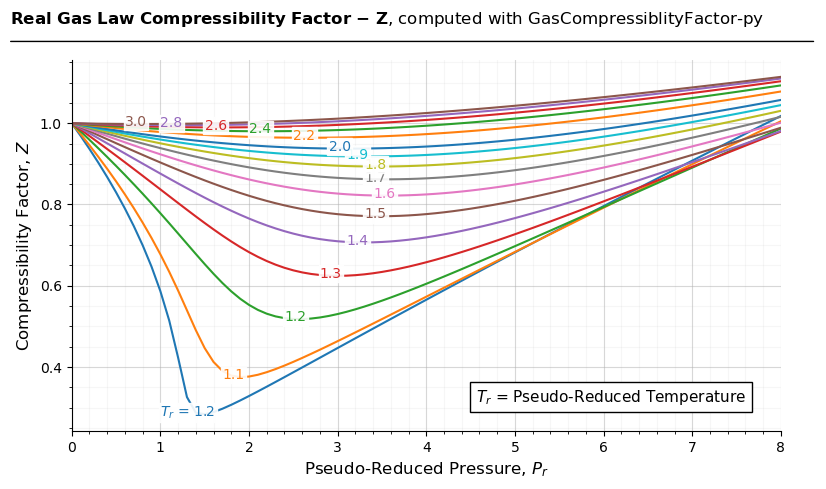

In [14]:
import gascompressibility as gascomp

results, fig, ax = gascomp.zfactor().quickstart()

In [15]:
fig.savefig('z-correlation chart.png', dpi=200)

In [5]:
a

1

In [175]:
zfactor('piper').calc_Z(P=2010, T=75, Tpc=373.6, J=0.4995)

0.7418815034924504

In [148]:
zfactor('piper').calc_Z(T=75, sg=0.7, P=2010)

0.7370643378633674

## Test J

In [149]:
zfactor('piper').calc_J(sg=0.7, H2S=0.07, CO2=0.1, N2=0)

0.4995211795770008

In [150]:
zfactor('piper').calc_J(sg=0.7, H2S=0.07, CO2=0.1, N2=0.1)

0.4690612564250918

In [151]:
zfactor('piper').calc_J(sg=0.7)

0.56221847

## Test K

In [152]:
zfactor('piper').calc_K(sg=0.7, H2S=0.07, CO2=0.1, N2=0)

13.661213066633309

In [153]:
zfactor('piper').calc_K(sg=0.7, H2S=0.07, CO2=0.1, N2=0.1)

12.727096764135345

In [154]:
zfactor('piper').calc_K(sg=0.7)

14.450840999999999

## Test Tpc

In [155]:
zfactor('piper').calc_Tpc(K=13.661, J=0.4995)

373.61946146146147

In [156]:
zfactor('piper').calc_Tpc(sg=0.7, H2S=0.07, CO2=0.1, N2=0)

373.6152741511213

In [157]:
zfactor('piper').calc_Tpc(sg=0.7, H2S=0.07, CO2=0.1, N2=0.5)

232.7950339652756

## Test Ppc

In [158]:
zfactor('piper').calc_Ppc(Tpc=373.6, J=0.4995)

747.947947947948

In [159]:
zfactor('piper').calc_Ppc(K=13.661, J=0.4995)

747.9869098327557

In [160]:
zfactor('piper').calc_Ppc(sg=0.7, CO2=0.1, H2S=0.07)

747.9468127207383

## Test Pr

In [161]:
zfactor('piper').calc_Pr(Tpc=373.6, sg=0.7, P=2010, H2S=0.07, CO2=0.1)

2.687466731664271

In [162]:
zfactor('piper').calc_Pr(Ppc=747.9, P=2010)

2.6875250701965503

In [163]:
zfactor('piper').calc_Pr(P=2010, K=4, J=2)

502.5

In [164]:
zfactor('piper').calc_Pr(P=2010, sg=2)

3.8686451504335713

In [165]:
zfactor('piper').calc_Pr(P=2010, Tpc=373.6, J=0.4995)

2.6873527837259097

## Test Tr

In [166]:
zfactor('piper').calc_Tr(T=75, sg=0.7, H2S=0.07, CO2=0.1)

1.431071042838936

In [167]:
zfactor('piper').calc_Tr(T=75, K=13.661, J=0.4995)

1.431055004224267

In [168]:
zfactor('piper').calc_Tr(T=75, Tpc=373.6)

1.4311295503211992

## Test Z

In [193]:
zfactor('piper').calc_Z(P=2010, T=75, sg=0.7, H2S=0.07, CO2=0.1, N2=0.1)

0.8093081653980262

In [192]:
zfactor('piper').calc_Z(P=2010, T=75, sg=0.7, H2S=0.07, CO2=0.1)

0.7418404080772932

In [177]:
zfactor('piper').calc_Z(P=2010, T=75, K=13.661, J=0.4995)

0.7418351281782508

In [178]:
zfactor('piper').calc_Z(P=2010, T=75, Tpc=373.6, J=0.4995)

0.7418815034924504

In [189]:
zfactor('piper').calc_Z(P=2010, T=75, Pr=2.687, K=13.661, J=0.4995)

0.7418439061899736

In [122]:
print(aa.Pr)
print(aa.Tr)

2.687356862566745
1.431071042838936


In [98]:
3.8216 \
                 - 0.06534 * H2S * (Tc_H2S / np.sqrt(Pc_H2S)) \
                 - 0.42113 * CO2 * (Tc_CO2 / np.sqrt(Pc_CO2)) \
                 - 0.91249 * N2 * (Tc_N2 / np.sqrt(Pc_N2)) \
                 + 17.438 * sg \
                 - 3.2191 * sg ** 2

13.661213066633309

In [97]:
3.2191 * sg ** 2

1.5773589999999997

In [70]:
print(aa.N2)
print(aa.CO2)
print(aa.H2S)

0
0.1
0.07


In [65]:
aa.K

-9.986241845719988

In [66]:
aa.J

-0.4906848204229992

In [67]:
aa.sg

0.7

In [68]:
print(aa.Tc_H2S)
print(aa.Pc_H2S)

672.3
1306


In [69]:
print(aa.Tc_CO2)
print(aa.Pc_CO2)

547.5
1071


In [61]:
print(aa.Tc_N2)
print(aa.Pc_N2)

227.16
492.4


In [439]:
aa.calc_Z(P=2010, T=75, CO2=0.1, H2S=0.07, sg=0.7)
print(aa.Ppc_corrected)
print(aa.Tpc_corrected)
print(aa.Pr)
print(aa.Tr)
print(aa.Z)

628.2143047814683
356.31219397078127
3.1995450990234966
1.5005661019949397
0.7730732979666094


In [442]:
aa.calc_Z(P=2010, T=75, Ppc=747.9, Tpc=373.6)
print(aa.Pr)
print(aa.Tr)
print(aa.Z)

2.6875250701965503
1.4311295503211992
0.7418744010634963


In [422]:
aa.calc_Pr(Ppc=663.29, Tpc=377.59, P=2010, e_correction=21.278)

TypeError: Missing a required argument, H2S, (mole fraction of H2S, dimensionless)

In [365]:
aa.Tpc

377.59

In [375]:
aa.calc_Tr(sg=0.7, T=75, Tpc_corrected=356.31)

1.5005753416968373

In [209]:
aa.calc_Ppc_corrected(sg=0.7, H2S=0.07, CO2=0.1, e_correction=21.278)

333333
0.07
0
0.07
44444444
21.278


628.2139838777422

In [211]:
aa.calc_Ppc_corrected(sg=0.7, H2S=0.07, CO2=0.1)

333333
0.07
---------
++++++
None
None
0.07
0.1
++++++
0.17
0.07
44444444
None
---------
++++++
None
None
0
0
++++++


663.2869999999999

In [198]:
aa.e_correction

0.0

In [199]:
aa.A

0

In [200]:
aa.B

0

In [129]:
aa.calc_Ppc_corrected(sg=0.7, H2S=0.07)

364.3662538443467

In [128]:
aa.calc_Tpc_corrected(sg=0.7, e_correction=21.278)

356.31199999999995

In [130]:
aa.calc_Tpc_corrected(Tpc=377.59, e_correction=21.278)

356.31199999999995

In [2]:
import matplotlib.pyplot as plt

In [109]:
xmax = 8
Prs = np.linspace(0, xmax, xmax * 10 + 1)
Trs = [1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

results = {Tr: [] for Tr in Trs}
for Tr in Trs:
    for Pr in Prs:
        z = Z_factor().calc_Z(Tr=Tr, Pr=Pr, **{'maxiter': 1000})
        results[Tr].append(z)

C:\Users\EricKim\AppData\Local\Temp\ipykernel_12360\954759431.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', alpha=0.1)


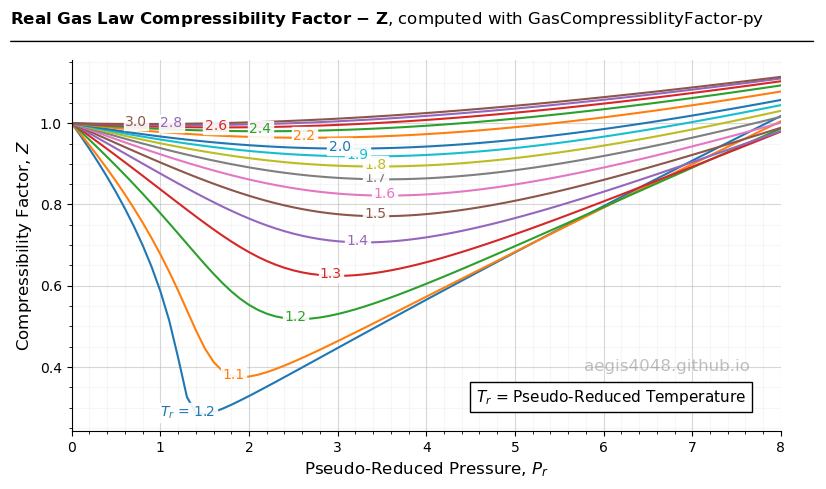

In [110]:
label_fontsize = 12

fig, ax = plt.subplots(figsize=(8, 5))
for Tr in Trs:
    
    Zs = results[Tr]
    idx_min = Zs.index(min(Zs))
    
    p = ax.plot(Prs, Zs)
    if Tr == 1.05:
        t = ax.text(Prs[idx_min] - 0.5, min(Zs) - 0.005, '$T_{r}$ = 1.2', color=p[0].get_color())
        t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white', pad=1))       
    else:
        t = ax.text(Prs[idx_min] - 0.2, min(Zs) - 0.005, Tr, color=p[0].get_color())
        t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white', pad=1))

ax.set_xlim(0, xmax)
ax.minorticks_on()
ax.grid(alpha=0.5)
ax.grid(b=True, which='minor', alpha=0.1)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_ylabel('Compressibility Factor, $Z$', fontsize=label_fontsize)
ax.set_xlabel('Pseudo-Reduced Pressure, $P_{r}$', fontsize=label_fontsize)
ax.text(0.57, 0.08, '$T_{r}$ = Pseudo-Reduced Temperature', fontsize=11, transform=ax.transAxes, bbox=dict(facecolor='white'))
ax.text(7.65, 0.42, 'aegis4048.github.io', fontsize=label_fontsize, ha='right', va='top', color='grey', alpha=0.5)

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])

ax.set_title(setbold('Real Gas Law Compressibility Factor - Z')  + ", computed with GasCompressiblityFactor-py ", fontsize=12, pad=10, x=0.445, y=1.06)
ax.annotate('', xy=(-0.09, 1.05), xycoords='axes fraction', xytext=(1.05, 1.05), arrowprops=dict(arrowstyle="-", color='k'))

fig.tight_layout()

In [7]:
import matplotlib.pyplot as plt

In [133]:
Prs = np.linspace(0, 8, 81)
Trs = [1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

results = {Tr: [] for Tr in Trs}
for Tr in Trs:
    for Pr in Prs:
        z = Z_factor().calc_Z(Tr=Tr, Pr=Pr, **{'maxiter': 1000})
        results[Tr].append(z)

C:\Users\EricKim\AppData\Local\Temp\ipykernel_13736\1567171423.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', alpha=0.1)


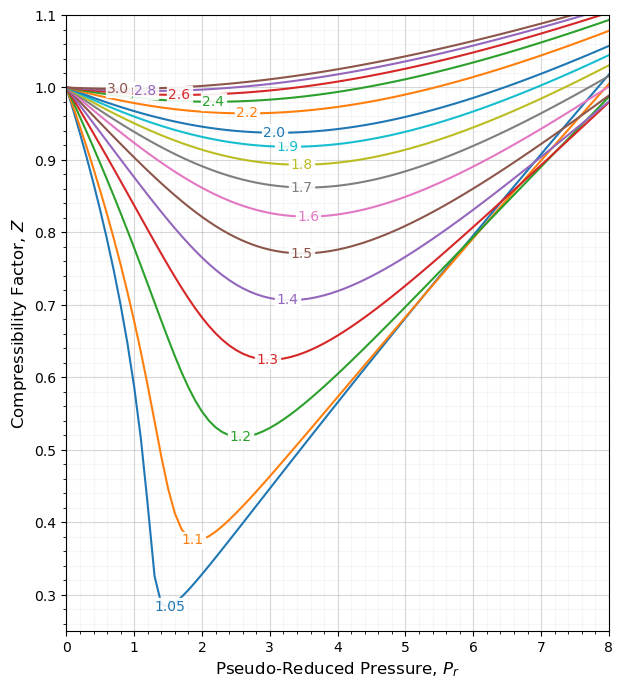

In [134]:
label_fontsize = 12

fig, ax = plt.subplots(figsize=(7, 8))
for Tr in Trs:
    
    Zs = results[Tr]
    idx_min = Zs.index(min(Zs))
    
    p = ax.plot(Prs, Zs)
    ax.set_ylim(0.25, 1.1)
    ax.set_xlim(0, 8)
    
    t = ax.text(Prs[idx_min] - 0.2, min(Zs) - 0.005, Tr, color=p[0].get_color())
    t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white', pad=1))
    
    ax.minorticks_on()
    ax.grid(alpha=0.5)
    ax.grid(b=True, which='minor', alpha=0.1)
    
    ax.set_ylabel('Compressibility Factor, $Z$', fontsize=label_fontsize)
    ax.set_xlabel('Pseudo-Reduced Pressure, $P_{r}$', fontsize=label_fontsize)

In [135]:
Prs = np.linspace(7, 15, 81)
Trs = [1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

results = {Tr: [] for Tr in Trs}
for Tr in Trs:
    for Pr in Prs:
        z = Z_factor().calc_Z(Tr=Tr, Pr=Pr, **{'maxiter': 1000})
        results[Tr].append(z)

C:\Users\EricKim\AppData\Local\Temp\ipykernel_13736\3204600190.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', alpha=0.1)


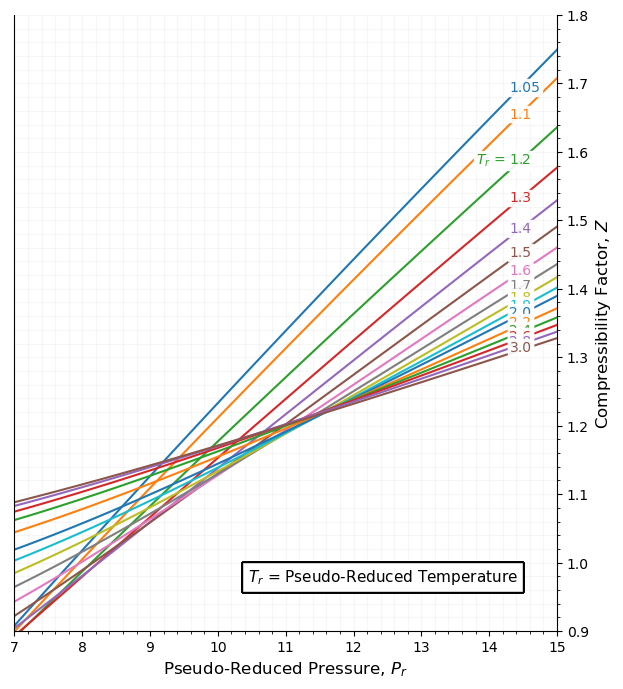

In [137]:
label_fontsize = 12

fig, ax = plt.subplots(figsize=(7, 8))

for Tr in Trs:
    
    Zs = results[Tr]
    idx_min = Zs.index(min(Zs))
    
    p = ax.plot(Prs, Zs)
    ax.set_ylim(0.9, 1.8)
    ax.set_xlim(7, 15)

    if Tr == 1.2:
        t = ax.text(Prs[-8] - 0.5, Zs[-7], '$T_{r}$ = 1.2', color=p[0].get_color())
        t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white', pad=1))        
    else:
        t = ax.text(Prs[-8], Zs[-7], Tr, color=p[0].get_color())
        t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white', pad=1))
    
    ax.minorticks_on()
    ax.grid(alpha=0.1)
    ax.grid(b=True, which='minor', alpha=0.1)
    
    ax.yaxis.tick_right()
    
    ax.set_ylabel('Compressibility Factor, $Z$', fontsize=label_fontsize)
    ax.yaxis.set_label_position('right') 
    ax.set_xlabel('Pseudo-Reduced Pressure, $P_{r}$', fontsize=label_fontsize)
    ax.spines.top.set_visible(False)
    
    ax.text(0.43, 0.08, '$T_{r}$ = Pseudo-Reduced Temperature', fontsize=11, 
            transform=ax.transAxes, bbox=dict(facecolor='white'))
    
fig.savefig('zplot_2.png', dpi=200)

In [129]:
Prs = np.linspace(0, 8, 81)
Trs = [1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]

results = {Tr: [] for Tr in Trs}
for Tr in Trs:
    for Pr in Prs:
        z = Z_factor().calc_Z(Tr=Tr, Pr=Pr, **{'maxiter': 1000})
        results[Tr].append(z)

C:\Users\EricKim\AppData\Local\Temp\ipykernel_13736\1578593572.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='minor', alpha=0.1)


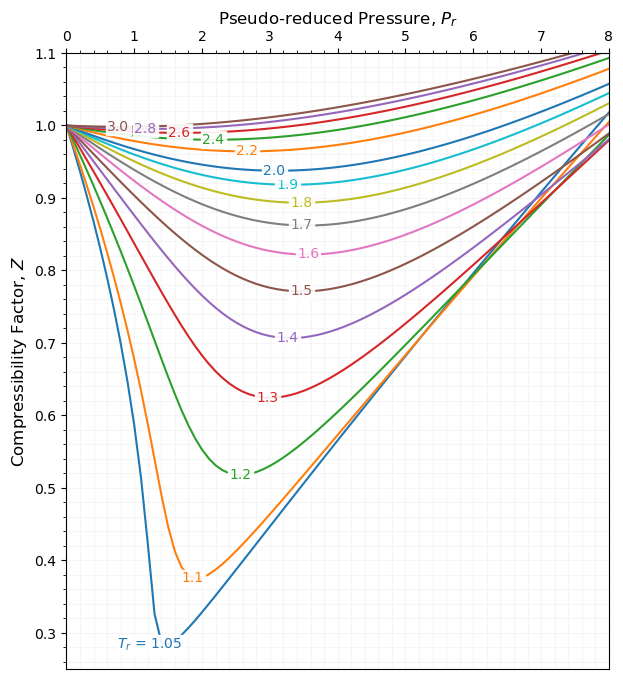

In [130]:
label_fontsize = 12

fig, ax = plt.subplots(figsize=(7, 8))
for Tr in Trs:
    
    Zs = results[Tr]
    idx_min = Zs.index(min(Zs))
    
    p = ax.plot(Prs, Zs)
    ax.set_ylim(0.25, 1.1)
    ax.set_xlim(0, 8)
    
    if Tr == 1.05:
        t = ax.text(Prs[idx_min] - 0.75, min(Zs) - 0.005, '$T_{r}$ = 1.05', color=p[0].get_color())
        t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white', pad=1))        
    else:
        t = ax.text(Prs[idx_min] - 0.2, min(Zs) - 0.005, Tr, color=p[0].get_color())
        t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white', pad=1))
    
    ax.minorticks_on()
    ax.grid(alpha=0.1)
    ax.grid(b=True, which='minor', alpha=0.1)
    
    #ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_ylabel('Compressibility Factor, $Z$', fontsize=label_fontsize)
    ax.set_xlabel('Pseudo-reduced Pressure, $P_{r}$', fontsize=label_fontsize)
    ax.xaxis.set_label_position('top') 
    
fig.savefig('zplot_1.png', dpi=200)

In [54]:
z_obj = Z_factor()
z_obj.calc_Pr(H2S=0.07, CO2=0.1, P=2010, Ppc=663.29, Tpc=377.59)

print('Attributes --------------------------------------')
print('A             = ', z_obj.A)
print('B             = ', z_obj.B)
print('e_correction  = ', round(z_obj.e_correction, 2))
print('Ppc_corrected = ', round(z_obj.Ppc_corrected, 2))
print('Tpc_corrected = ', round(z_obj.Tpc_corrected, 2))
print('Result ------------------------------------------')
print('Tpr           = ', round(z_obj.Pr, 4))

Attributes --------------------------------------
A             =  0.17
B             =  0.07
e_correction  =  21.28
Ppc_corrected =  628.22
Tpc_corrected =  356.31
Result ------------------------------------------
Tpr           =  3.1995
